In [16]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import io

# Data Loading

In [2]:
device = "cpu"

In [3]:
img_size = 192

class FlowerDataset(Dataset):
    def __init__(self, id, classes, image, mean, std, img_height=img_size, img_width=img_size):
        self.id = id
        self.classes = classes
        self.image = image
        self.img_width = img_width
        self.img_height = img_height

    def __len__(self):
        return len(self.id)

    def __getitem__(self, index):
        id = self.id[index]
        img = np.array(Image.open(io.BytesIO(self.image[index])))
        img = cv2.resize(img, dsize=(128,128), interpolation=cv2.INTER_CUBIC) # i know this is hard coded, its effort to fix(I'd have to recreate the original .pt file), so this is how it stays
        img = self.aug(image=img)["image"]
        img = np.transpose(img, (2,0,1)).astype(np.float32)

        return torch.tensor(img, dtype=torch.float), int(self.classes[index])

In [4]:
dataset: Dataset = torch.load("train_dataset_192.pt")
loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [5]:
batch = next(iter(loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


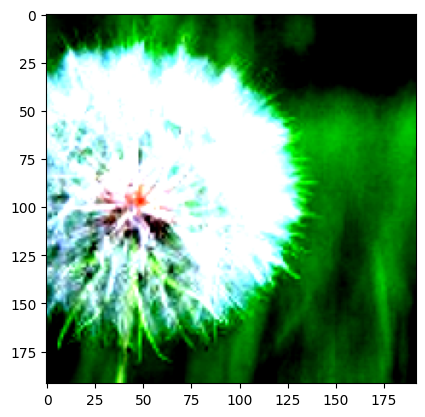

In [6]:
plt.imshow(batch[0][0].permute(1,2,0))

In [28]:
len(dataset)

12753

# How many labels?

In [48]:
labels = set()
temp_loader = DataLoader(dataset, batch_size=500)

for j in range(12753//500 + 1):
    iterater = iter(temp_loader)
    data = next(iterater)[1]
    for i in data:
        labels.add(i.item())
    print(f"batch {j}")

print(len(labels))
print(labels)


batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
92
{0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 59, 60, 61, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103}


In [39]:
torch.unique(data[1])

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103])

# Neural Network time

In [7]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Our net will be built out of Convolution -> Batch Normalization -> ReLU -> MaxPool2d -> Halve channels steps, with skip connections

In [8]:
class Block(nn.Module):
    def __init__(self, n_channels, kernel_size=3, padding = 1, pooling=2) -> None:
        super(Block, self).__init__()

        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.pooling = pooling

        self.conv = nn.Conv2d(
            self.n_channels, 
            self.n_channels, 
            kernel_size=self.kernel_size, 
            padding=self.padding, 
            bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_channels)
        self.pool = nn.MaxPool2d(self.pooling)

        # initialise these
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity="relu")
        nn.init.constant_(self.batch_norm.weight, 0.5)
        nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        print(x.shape)
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        out = self.pool(out)
        out = out + self.pool(x)
        out = nn
        return out #+ self.pool(x) # includes the skip connection


class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.nchans1 = 32
        self.conv1 = nn.Conv2d(3, self.nchans1, kernel_size=3, stride=1, padding=1)

        self.blocks = nn.Sequential(
            Block(self.nchans1, 2),
            Block(self.nchans1, 2),
            Block(self.nchans1, 2),
            Block(self.nchans1, 2),
            Block(self.nchans1, 2),
        )

        self.linear1 = nn.Linear(256, 104)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.blocks(out)
        out = out.view(-1, 256)
        out = self.linear1(out)
        return out

In [12]:
class SimpleNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.nchans_init = 32

        self.conv1 = nn.Conv2d(3, self.nchans_init, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(self.nchans_init, self.nchans_init//2, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(num_features=16)
        self.pool2 = nn.MaxPool2d(2)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity="relu")
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity="relu")
        nn.init.constant_(self.batchnorm1.weight, 0.5)
        nn.init.constant_(self.batchnorm2.weight, 0.5)
        nn.init.zeros_(self.batchnorm1.bias)
        nn.init.zeros_(self.batchnorm1.bias)

        self.fc1 = nn.Linear(48*48*self.nchans_init//2, 104)

    def forward(self, x):

        out1 = self.pool1(self.batchnorm1(self.conv1(x)))
        out1 = torch.relu(out1)

        out2 = self.pool2(self.batchnorm2(self.conv2(out1)))
        out2 = torch.relu(out2)
        del out1

        out = out2.view(-1, 48*48*self.nchans_init//2)
        del out2

        out = self.fc1(out)
        return out

# Training

In [10]:
device="cpu"

In [14]:
import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.

        for imgs, labels in train_loader:
            
            # set device
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            # feed data through model
            outputs = model(imgs)

            # calculate loss
            loss = loss_fn(outputs, labels)

            # remove gradients from last round
            optimizer.zero_grad()

            # compute gradients of all parameters we are trying to learn
            loss.backward()

            # update the model
            optimizer.step()

            # sum all the losses over the epoch
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            # display average loss per batch
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  

In [17]:
reduced_dataset = Subset(dataset, range(0, 100))
reduced_loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = SimpleNet().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = reduced_loader,
)

KeyboardInterrupt: 